# 🏠 House Prices 이상값(outlier) 분석 실습 (정답 포함)

이 노트북은 Kaggle House Prices 데이터셋(`House Prices - Advanced Regression Techniques.csv`)을 사용해
이상값(outlier)을 탐지하고 처리(drop/clip)하는 과정을 실습하기 위한 문제집입니다.

주요 목표
1. 이상값 후보 시각화(Boxplot, Scatter)
2. IQR 기반 이상값 경계 계산
3. 이상치 행 추출/분석
4. 이상치 처리 전략 (제거 vs 클리핑)
5. 처리 전/후 데이터 분포 비교 및 해석

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_csv("./data/05_House Prices - Advanced Regression Techniques.csv")
df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 문제 1️⃣: 핵심 수치형 변수 살펴보기
- 아래 변수들에 대해 describe()로 기본 통계를 확인하세요.
  - SalePrice (집값)
  - LotArea (대지 면적)
  - GrLivArea (지상 생활 면적)
  - GarageArea (차고 면적)
- 어느 변수가 특히 오른쪽 꼬리가 긴(극단적으로 큰 값이 많은) 분포처럼 보이는지 적으세요.

In [2]:
cols = ['SalePrice', 'LotArea', 'GrLivArea', 'GarageArea']
df[cols].describe().T


,count,mean,std,min,25%,50%,75%,max
SalePrice,1460.0,180921.195890,79442.502883,34900.0,129975.0,163000.0,214000.00,755000.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.5,9478.5,11601.50,215245.0
GrLivArea,1460.0,1515.463699,525.480383,334.0,1129.5,1464.0,1776.75,5642.0
GarageArea,1460.0,472.980137,213.804841,0.0,334.5,480.0,576.00,1418.0


## 문제 2️⃣: 박스플롯 & 산점도 시각화
1. `SalePrice`, `LotArea`, `GrLivArea`, `GarageArea` 각각 박스플롯(boxplot)으로 시각화하세요.
2. `GrLivArea` vs `SalePrice` 산점도를 그려서, 면적이 큰 집이 정말 비싼지/이상하게 싼지 확인하세요.

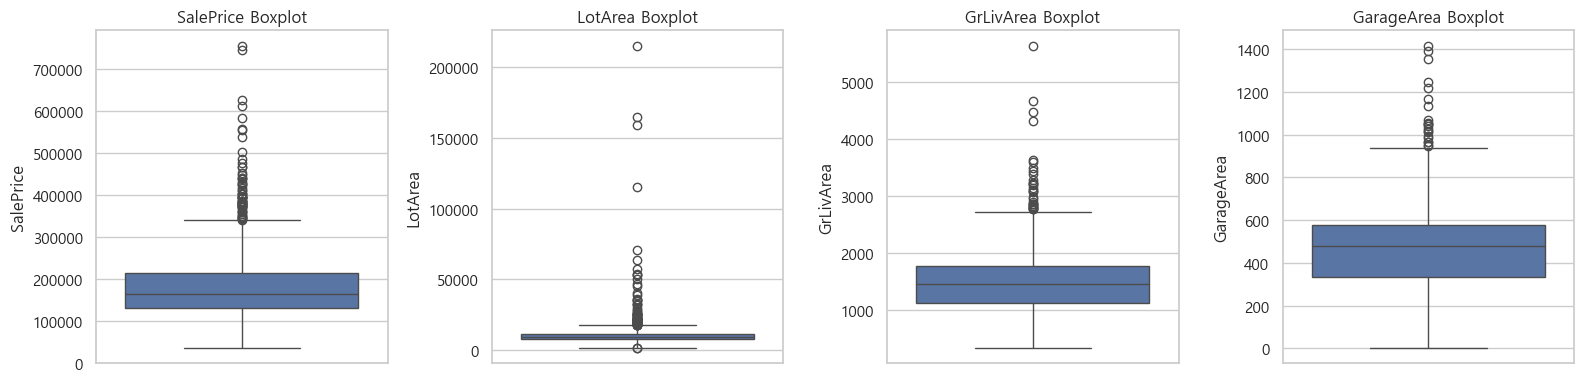

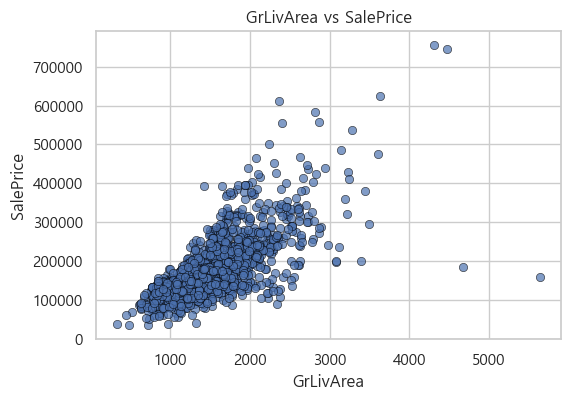

In [3]:
fig, axes = plt.subplots(1,4,figsize=(16,4))
for ax, col in zip(axes, ['SalePrice','LotArea','GrLivArea','GarageArea']):
    sns.boxplot(y=df[col], ax=ax)
    ax.set_title(col + ' Boxplot')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df, edgecolor='black', alpha=0.7)
plt.title('GrLivArea vs SalePrice')
plt.show()


## 문제 3️⃣: IQR 기반 이상값 경계 (SalePrice)
1. `SalePrice`의 Q1(25%), Q3(75%), IQR(Q3-Q1)을 구하세요.
2. IQR 방식으로 lower_bound, upper_bound를 계산하세요.
   - lower = Q1 - 1.5 * IQR
   - upper = Q3 + 1.5 * IQR
3. 이 범위를 벗어나는 행의 개수와, 전체 대비 비율(%)을 구하세요.

In [4]:
Q1 = df['SalePrice'].quantile(0.25)
Q3 = df['SalePrice'].quantile(0.75)
IQR = Q3 - Q1
lower_price = Q1 - 1.5 * IQR
upper_price = Q3 + 1.5 * IQR

outliers_price = df[(df['SalePrice'] < lower_price) | (df['SalePrice'] > upper_price)]
count_out = len(outliers_price)
ratio_out = count_out / len(df) * 100

print('Q1:', Q1, 'Q3:', Q3, 'IQR:', IQR)
print('lower_bound:', lower_price, 'upper_bound:', upper_price)
print('이상치 개수:', count_out)
print('전체 대비 비율(%):', ratio_out)


Q1: 129975.0 Q3: 214000.0 IQR: 84025.0
lower_bound: 3937.5 upper_bound: 340037.5
이상치 개수: 61
전체 대비 비율(%): 4.178082191780822


## 문제 4️⃣: 면적 관련 이상값 탐지 (GrLivArea, LotArea)
GrLivArea와 LotArea 각각에 대해:
1. Q1, Q3, IQR 계산
2. lower_bound, upper_bound 계산
3. 경계를 벗어나는 데이터 개수 출력
4. GrLivArea 이상치들만 모아서 그들의 SalePrice를 확인하고,
   '면적은 엄청 큰데 집값은 상대적으로 안 비싼' 케이스가 있는지 살펴보세요.

In [5]:
results = {}
for col in ['GrLivArea','LotArea']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask_out = (df[col] < lower) | (df[col] > upper)
    results[col] = {'Q1':Q1,'Q3':Q3,'IQR':IQR,'lower':lower,'upper':upper,'outliers':mask_out.sum()}
    print(f'[{col}] 이상치 개수:', mask_out.sum())

# GrLivArea 이상치 행만 보고 SalePrice 비교
col = 'GrLivArea'
Q1 = df[col].quantile(0.25); Q3 = df[col].quantile(0.75); IQR = Q3-Q1
lower = Q1 - 1.5*IQR; upper = Q3 + 1.5*IQR
grliv_outliers = df[(df[col] < lower) | (df[col] > upper)][['GrLivArea','SalePrice','OverallQual','Neighborhood']]
grliv_outliers.head()


[GrLivArea] 이상치 개수: 31
[LotArea] 이상치 개수: 69


,GrLivArea,SalePrice,OverallQual,Neighborhood
58,2945,438780,10,StoneBr
118,3222,320000,7,SawyerW
185,3608,475000,10,OldTown
197,3112,235000,8,NAmes
231,2794,403000,8,NoRidge


## 문제 5️⃣: 이상치 상세 살펴보기
위에서 찾은 GrLivArea 이상치들만 따로 df_outlier_area 데이터프레임으로 저장하고
해당 샘플들의 `GrLivArea`, `SalePrice`, `OverallQual`, `Neighborhood`를 출력하세요.
이 샘플들이 특정 동네에 몰려 있는지, 품질 점수(OverallQual)가 낮은데 크기만 큰 집은 있는지 서술하세요.

In [6]:
col = 'GrLivArea'
Q1 = df[col].quantile(0.25); Q3 = df[col].quantile(0.75); IQR = Q3-Q1
lower = Q1 - 1.5*IQR; upper = Q3 + 1.5*IQR

df_outlier_area = df[(df[col] < lower) | (df[col] > upper)][['GrLivArea','SalePrice','OverallQual','Neighborhood']]

print('이상치 샘플 수:', len(df_outlier_area))
df_outlier_area.head()


이상치 샘플 수: 31


,GrLivArea,SalePrice,OverallQual,Neighborhood
58,2945,438780,10,StoneBr
118,3222,320000,7,SawyerW
185,3608,475000,10,OldTown
197,3112,235000,8,NAmes
231,2794,403000,8,NoRidge


## 문제 6️⃣: 이상치 처리 전략 1 - 제거(drop)
GrLivArea를 기준으로 IQR 바깥의 이상치를 제거한 새로운 DataFrame `df_clean_drop`을 만드세요.
1. 제거 전(df) vs 제거 후(df_clean_drop)의 행 수 비교
2. 두 데이터프레임 각각에서 GrLivArea의 평균, 표준편차 비교

In [7]:
col = 'GrLivArea'
Q1 = df[col].quantile(0.25); Q3 = df[col].quantile(0.75); IQR = Q3-Q1
lower = Q1 - 1.5*IQR; upper = Q3 + 1.5*IQR

df_clean_drop = df[(df[col] >= lower) & (df[col] <= upper)].copy()

print('원본 행 수:', len(df), '| 제거 후 행 수:', len(df_clean_drop))
print('원본 GrLivArea mean/std:', df['GrLivArea'].mean(), df['GrLivArea'].std())
print('제거후 GrLivArea mean/std:', df_clean_drop['GrLivArea'].mean(), df_clean_drop['GrLivArea'].std())


원본 행 수: 1460 | 제거 후 행 수: 1429
원본 GrLivArea mean/std: 1515.463698630137 525.4803834232025
제거후 GrLivArea mean/std: 1476.7515745276417 449.9280558805569


## 문제 7️⃣: 이상치 처리 전략 2 - 클리핑(윈저라이징)
1. GrLivArea의 IQR 기반 lower_bound~upper_bound를 이용해
   GrLivArea를 그 범위 안으로 `clip()` 한 DataFrame `df_clip`을 만드세요.
2. 원본 df와 df_clip 각각에 대해 GrLivArea의 boxplot을 나란히 그리고 비교하세요.
3. 제거(drop) 방식과 비교했을 때 클리핑의 장단점을 서술하세요.

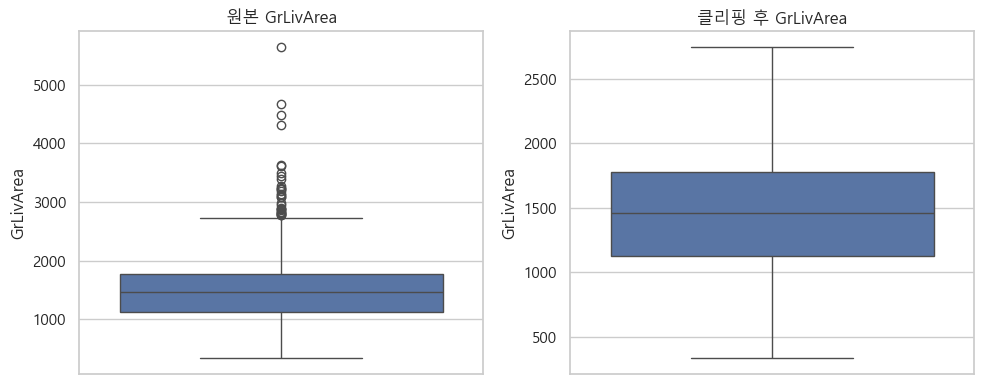

In [8]:
col = 'GrLivArea'
Q1 = df[col].quantile(0.25); Q3 = df[col].quantile(0.75); IQR = Q3-Q1
lower = Q1 - 1.5*IQR; upper = Q3 + 1.5*IQR

df_clip = df.copy()
df_clip[col] = df_clip[col].clip(lower, upper)

fig, axes = plt.subplots(1,2,figsize=(10,4))
sns.boxplot(y=df['GrLivArea'], ax=axes[0])
axes[0].set_title('원본 GrLivArea')
sns.boxplot(y=df_clip['GrLivArea'], ax=axes[1])
axes[1].set_title('클리핑 후 GrLivArea')
plt.tight_layout()
plt.show()


## 문제 8️⃣: 이상치 처리 후 SalePrice 영향
1. 원본 df, df_clean_drop, df_clip 각각에서 SalePrice의 평균과 표준편차를 비교하세요.
2. 극단적으로 비싼 집(초고가 주택)을 어떻게 다루느냐에 따라 평균 집값이 얼마나 달라지는지 서술하세요.
3. 만약 '일반적인 중간 가격대 주택의 시세 예측'을 목표로 하는 모델이라면 어떤 버전(df / df_clean_drop / df_clip)을 쓰는 게 적절하다고 생각하나요?

In [9]:
def summary_price(dframe, name):
    print(f'[{name}] rows={len(dframe)} '
          f'mean(SalePrice)={dframe["SalePrice"].mean():.2f} '
          f'std(SalePrice)={dframe["SalePrice"].std():.2f}')

summary_price(df, '원본')
try:
    summary_price(df_clean_drop, 'drop 후')
except NameError:
    print("df_clean_drop이 위에서 아직 안 만들어졌다면 먼저 문제 6을 실행하세요.")
try:
    summary_price(df_clip, 'clip 후')
except NameError:
    print("df_clip이 위에서 아직 안 만들어졌다면 먼저 문제 7을 실행하세요.")


[원본] rows=1460 mean(SalePrice)=180921.20 std(SalePrice)=79442.50
[drop 후] rows=1429 mean(SalePrice)=176714.09 std(SalePrice)=71254.17
[clip 후] rows=1460 mean(SalePrice)=180921.20 std(SalePrice)=79442.50


## 문제 9️⃣: 다변량 관점의 이상치
1. 산점도(GrLivArea vs SalePrice)를 다시 그리되,
   - GrLivArea가 IQR 상한보다 큰데
   - SalePrice는 전체 평균보다 낮은 샘플만 다른 색(예: 빨간색)으로 표시하세요.
2. 이런 집은 어떤 의미일 수 있는지 해석을 적으세요

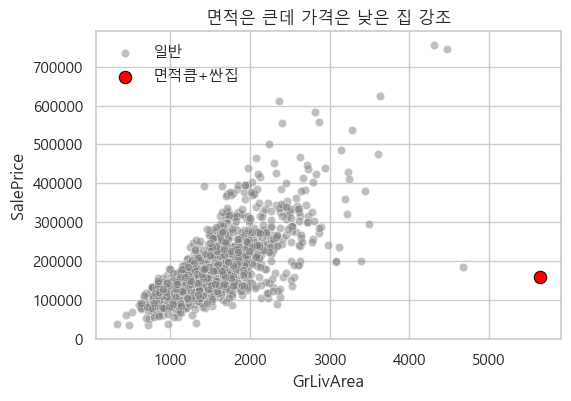

,GrLivArea,SalePrice,OverallQual,Neighborhood
1298,5642,160000,10,Edwards


In [10]:
col = 'GrLivArea'
Q1 = df[col].quantile(0.25); Q3 = df[col].quantile(0.75); IQR = Q3-Q1
_, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR

price_mean = df['SalePrice'].mean()
mask_suspicious = (df['GrLivArea'] > upper) & (df['SalePrice'] < price_mean)

plt.figure(figsize=(6,4))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df, color='gray', alpha=0.5, label='일반')
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df[mask_suspicious],
                color='red', edgecolor='black', s=80, label='면적큼+싼집')
plt.title('면적은 큰데 가격은 낮은 집 강조')
plt.legend(frameon=False)
plt.show()

df[mask_suspicious][['GrLivArea','SalePrice','OverallQual','Neighborhood']].head()


## 문제 🔟: 최종 의사결정 제안서 (서술형)
우리 팀이 만들 모델이 어떤 용도인지에 따라 이상치를 다루는 방식이 달라집니다.

- '일반적인 중간 가격대 주택의 시세 예측' 모델이라면 이상치를 제거하는 게 맞나요, 클리핑이 맞나요, 아니면 그대로 두나요?
- 초고가 주택까지 정확히 예측하는 모델을 만들려면 어떤 접근이 필요할까요?
- 당신의 추천 전략을 간단히 정리하세요.

### 예시 해설 아이디어
- 일반적인 주택 시세 예측이 목표라면: 극단적으로 큰 면적/초고가 주택은 전체 학습을 왜곡시키므로 제거(drop)하거나 clip으로 눌러서 영향력을 줄이는 편이 안정적이다.
- 초고가 주택까지 포함한 예측이 목표라면: 이상치를 함부로 제거하면 안 되고, 오히려 해당 샘플을 별도의 세그먼트(고급 주택 세그먼트)로 모델링하거나, 로그 변환 등으로 분포를 안정화한 뒤 회귀를 학습하는 접근이 낫다.
- 즉 이상치 처리는 기술 문제가 아니라 '우리가 예측하려는 시장 범위' 정의의 문제다.
